讀取來自新北市新店的房價資料集
資料集共6個特徵、1個目標值，有414筆資料

In [8]:
#先引入相關套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [9]:
df=pd.read_csv('data/Real estate dataset.csv')

In [10]:
#顯示前10筆
print(df.head(10))

   No  X1 transaction date  X2 house age  \
0   1             2012.917          32.0   
1   2             2012.917          19.5   
2   3             2013.583          13.3   
3   4             2013.500          13.3   
4   5             2012.833           5.0   
5   6             2012.667           7.1   
6   7             2012.667          34.5   
7   8             2013.417          20.3   
8   9             2013.500          31.7   
9  10             2013.417          17.9   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                84.87882                               10   
1                               306.59470                                9   
2                               561.98450                                5   
3                               561.98450                                5   
4                               390.56840                                5   
5                              2175.03000      

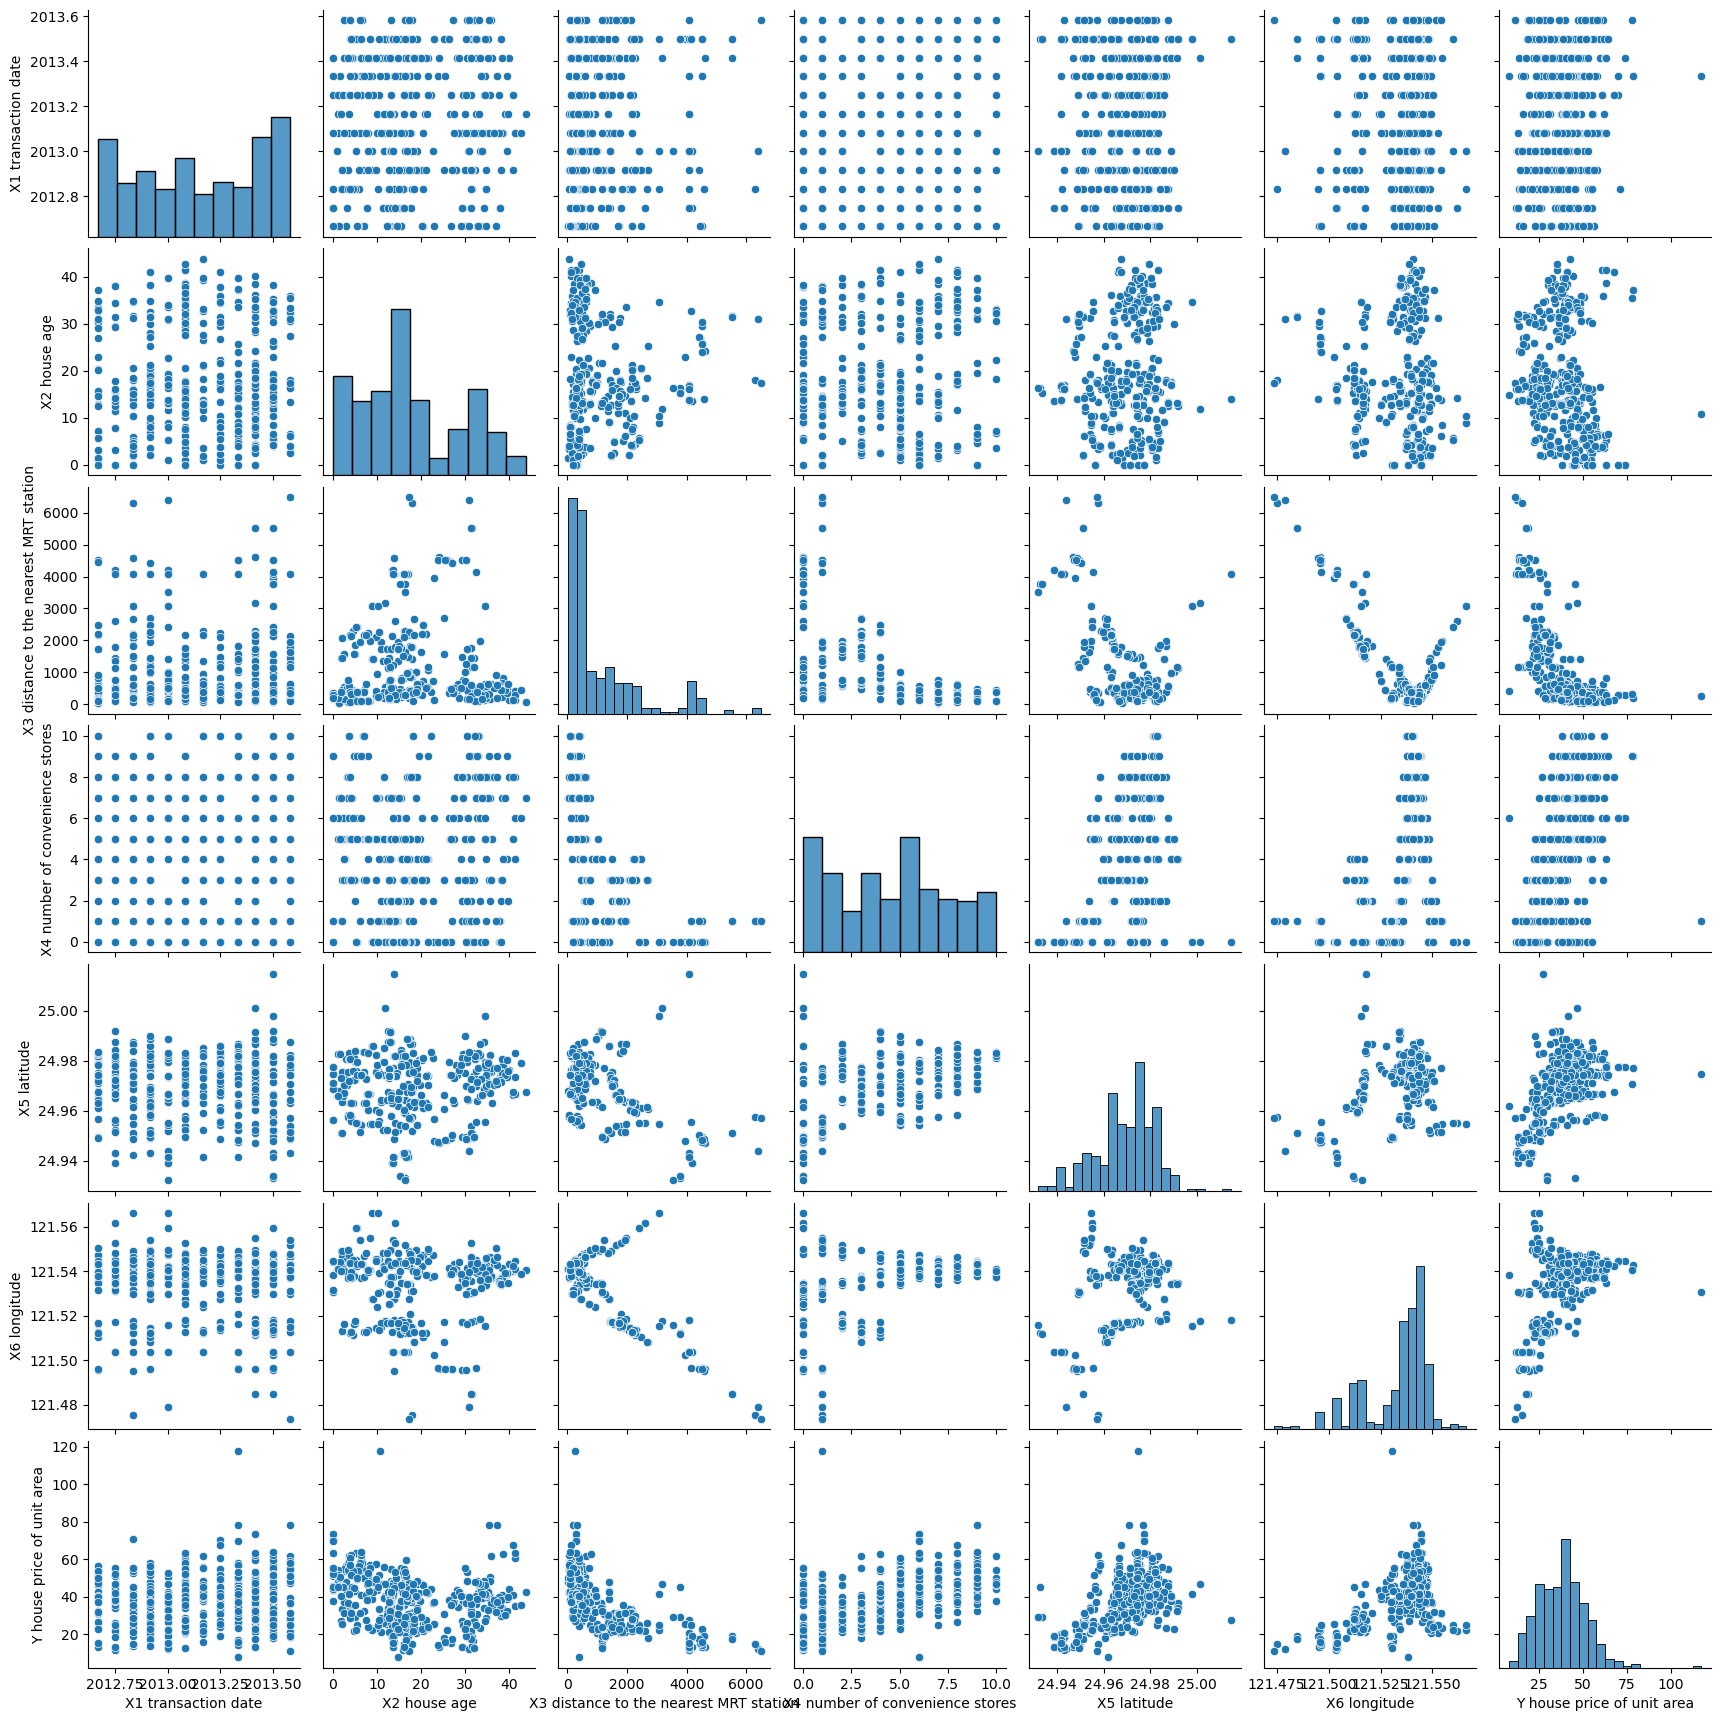

In [11]:
#以pairplot檢查多個特徵與房價之間的成對關係，查看變數間的分佈和關聯性
sns.pairplot(df, vars=['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores','X5 latitude','X6 longitude','Y house price of unit area'])
plt.show()

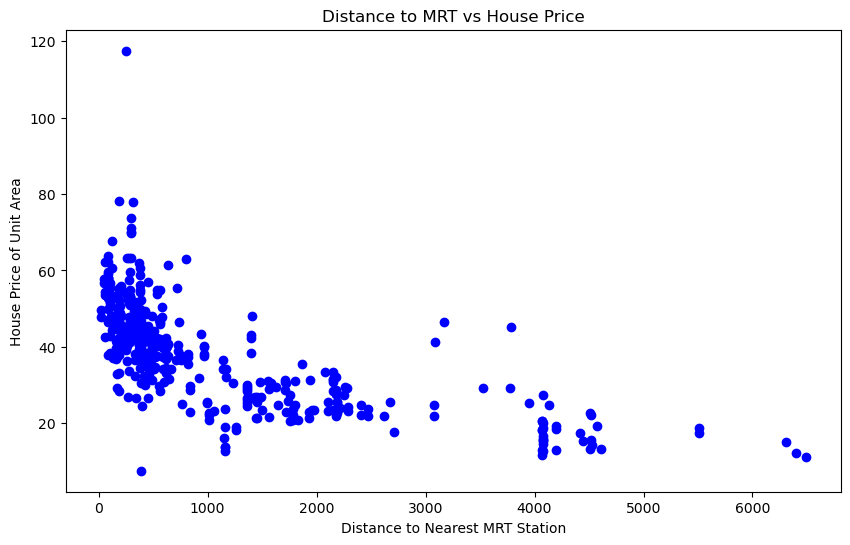

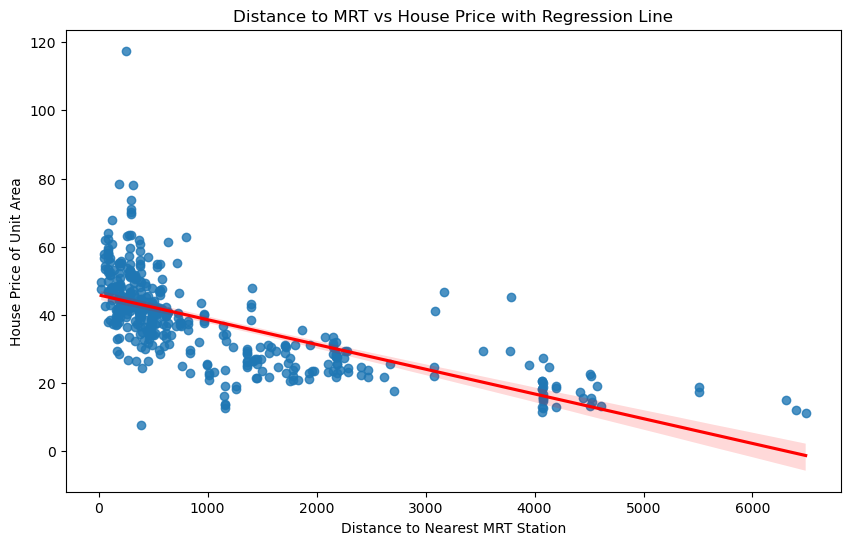

In [12]:
#發現「離最近捷運站的距離」和「房價」的影響關係特別明顯，於是進一步抓出研究
distance_to_mrt = df['X3 distance to the nearest MRT station'].values
house_price = df['Y house price of unit area'].values

#用 matplotlib 繪製散點圖
plt.figure(figsize=(10, 6))
plt.scatter(distance_to_mrt, house_price, color='blue')
plt.title('Distance to MRT vs House Price')
plt.xlabel('Distance to Nearest MRT Station')
plt.ylabel('House Price of Unit Area')
plt.show()

#用 seaborn 繪製散點圖並加入迴歸線
plt.figure(figsize=(10, 6))
sns.regplot(x=distance_to_mrt, y=house_price, line_kws={"color":"red"})
plt.title('Distance to MRT vs House Price with Regression Line')
plt.xlabel('Distance to Nearest MRT Station')
plt.ylabel('House Price of Unit Area')
plt.show()

我們發現，離最近捷運站的距離越近，房價就越高，兩者有非常明顯的負向關係
接著我想使用LSTM深度學習模型，來做房價預測

In [13]:
#先將6個特徵全部採納
features = ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station',
            'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']
target = 'Y house price of unit area'

#提取特徵和目標值，將資料轉換成Numpy
X = df[features].values
y = df[target].values

#對特徵進行縮放，確保每個特徵在相同的範圍內，也就是0到1
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

#對目標值進行縮放，因為目標變量是一維的，因此需要用 reshape(-1, 1)轉換為列向量，再進行縮放
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

#使用 create_dataset 函式將資料集轉換為LSTM格式
#for迴圈依序走訪特徵數據 X，用len(X) - time_step 保證循環不會超出數據的邊界
#從特徵數據 X 的第 i行開始，提取接下來的 time_step 行數據作為一個輸入樣本，形狀是 (time_step, 特徵數量)
#提取目標數據 y 中位於第 i + time_step 行的數值，作為對應的目標值
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []   
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step), :])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

#設定 time_step，即模型一次看到多少個連續的數據點
time_step = 10

#LSTM 的輸入和輸出
X_lstm, y_lstm = create_dataset(X_scaled, y_scaled, time_step)

# 切分訓練和測試集
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)

#印出確認
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (323, 10, 6)
y_train shape: (323, 1)
X_test shape: (81, 10, 6)
y_test shape: (81, 1)


In [14]:
#建立一個兩層LSTM 模型，每層後面加入Dropout層以防過擬合
#單層中有50個記憶單元（neurons），指定輸入數據的形狀，X_train.shape[1] 是時間步長的數量，X_train.shape[2] 是特徵的數量
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

#隨機丟棄20%的神經元，使模型更具泛化能力
model.add(Dropout(0.2))

#第二層LSTM層，並再dropout一次以防過擬合
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

#指定dense層有25個神經元，最終輸出預測的房價值
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型並保存訓練歷史
history = model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1, validation_data=(X_test, y_test))

# 預測訓練和測試數據
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向縮放預測值，與原始房價進行比較
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)

# 反向縮放真實值，將預測值轉換回原始房價的尺度
y_train_actual = scaler_y.inverse_transform(y_train)
y_test_actual = scaler_y.inverse_transform(y_test)

C:\Users\sunny\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - loss: 0.0546 - val_loss: 0.0211
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0222 - val_loss: 0.0212
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0223 - val_loss: 0.0150
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0191 - val_loss: 0.0153
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0198 - val_loss: 0.0139
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0171 - val_loss: 0.0147
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0170 - val_loss: 0.0152
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0160 - val_loss: 0.0136
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0165 - val_loss: 0.0135
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0181 - val_loss: 0.0136
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0182 - val_loss: 0.0136
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0183 - val_loss: 0.0133

In [15]:
# 計算 RMSE(均方根誤差)，以評估模型預測性能
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 13.873766714401297
Test RMSE: 12.579521519731777


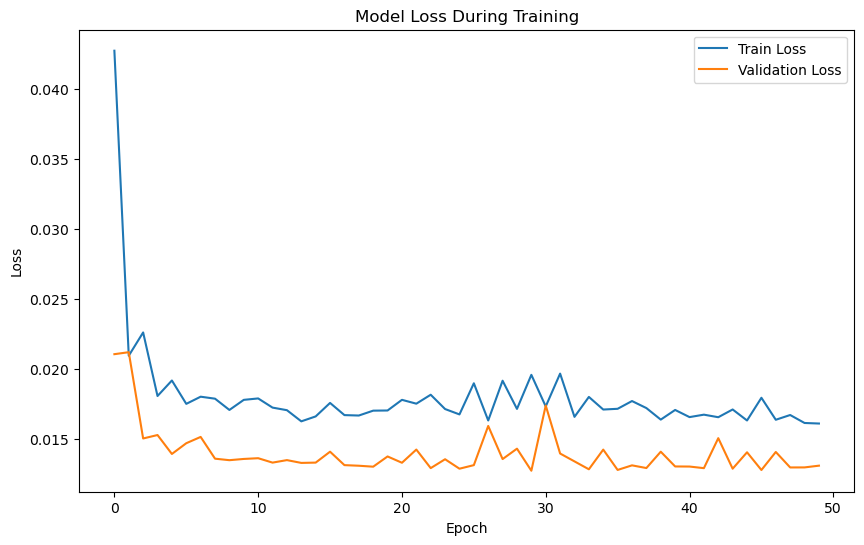

In [16]:
# 繪製訓練與驗證損失曲線
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

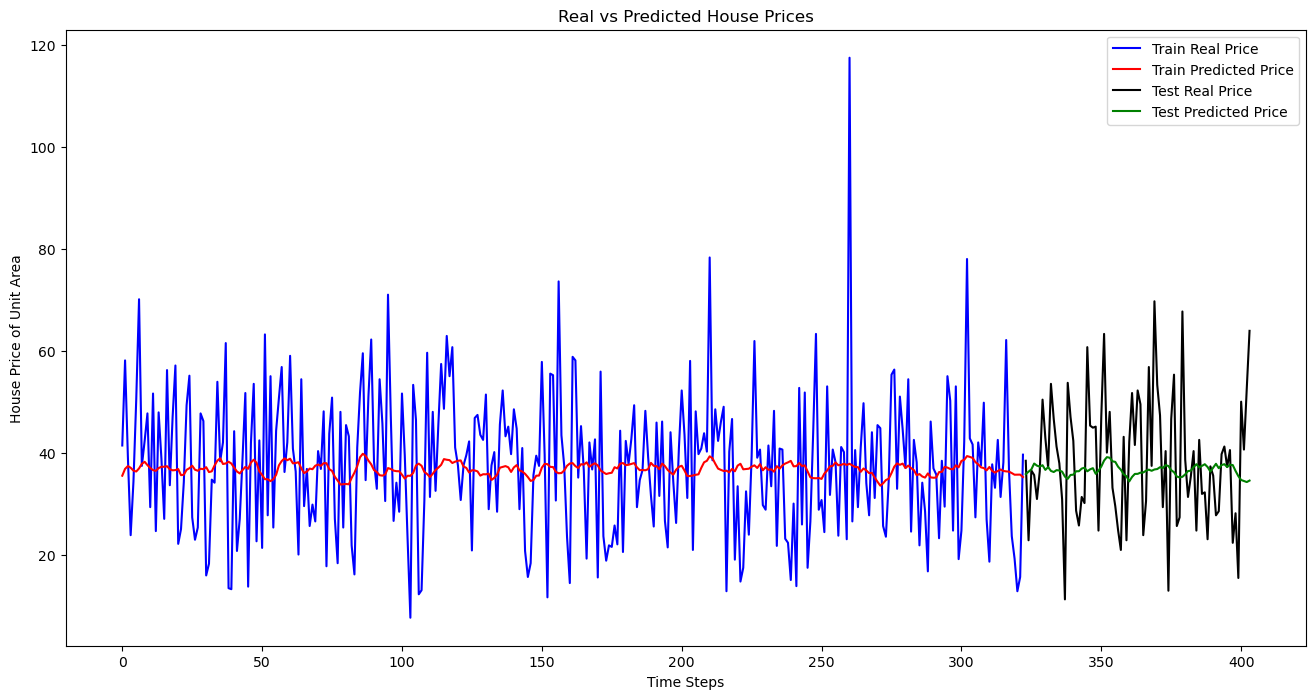

In [17]:
#繪製訓練集的真實房價和預測房價
plt.figure(figsize=(16, 8))

#訓練集預測，生成範圍 0 到 len(y_train_actual)-1 的數組，表示橫軸的時間步長
plt.plot(np.arange(len(y_train_actual)), y_train_actual, label='Train Real Price', color='blue')
plt.plot(np.arange(len(train_predict)), train_predict, label='Train Predicted Price', color='red')

#測試集預測，生成範圍從 len(y_train_actual)到 len(y_train_actual) + len(y_test_actual) 結束，將測試集的數據緊接在訓練集數據之後
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, label='Test Real Price', color='black')
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(test_predict)), test_predict, label='Test Predicted Price', color='green')

plt.title('Real vs Predicted House Prices')
plt.xlabel('Time Steps')
plt.ylabel('House Price of Unit Area')
plt.legend()
plt.show()

發現訓練集和測試集的RMSE都有點高，真實房價和預測房價也有落差，因此我想捨棄一些特徵，重做分析，觀察能否有更好結果

In [18]:
#去除掉相關性低的特徵
selected_features = ['X3 distance to the nearest MRT station', 'X4 number of convenience stores']

# 提取特徵和目標值
X = df[selected_features].values
y = df[target].values

# 縮放特徵和目標值
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 創建數據集
X_lstm, y_lstm = create_dataset(X_scaled, y_scaled, time_step=10)

# 切分訓練和測試集
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)

# 重訓模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 保存歷史並訓練
history = model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1, validation_data=(X_test, y_test))

# 預測並計算 RMSE
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
y_train_actual = scaler_y.inverse_transform(y_train)
y_test_actual = scaler_y.inverse_transform(y_test)

train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))

C:\Users\sunny\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - loss: 0.0601 - val_loss: 0.0145
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0236 - val_loss: 0.0138
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0199 - val_loss: 0.0148
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0194 - val_loss: 0.0137
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0168 - val_loss: 0.0135
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0176 - val_loss: 0.0133
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0177 - val_loss: 0.0131
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0187 - val_loss: 0.0131
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0183 - val_loss: 0.0132
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0184 - val_loss: 0.0130
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0188 - val_loss: 0.0134
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0171 - val_loss: 0.0129

In [19]:
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 13.932592631021476
Test RMSE: 12.422218393232404


誤差還是有點大...
我們採用KNN模型來試試看，是否會更好

In [28]:
#改用knn來與LSTM模型做比較
from sklearn.neighbors import KNeighborsRegressor

# 提取特徵和目標值
X = df[selected_features].values
y = df[target].values

# 縮放特徵和目標值
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 切分訓練和測試集
# 以shuffle=False確保時間序列順序
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# 創立 KNN 模型，K值設為4
knn = KNeighborsRegressor(n_neighbors=4) 
knn.fit(X_train, y_train.ravel())

# 預測
train_predict = knn.predict(X_train)
test_predict = knn.predict(X_test)

# 逆縮放預測和真實值
train_predict = scaler_y.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler_y.inverse_transform(test_predict.reshape(-1, 1))
y_train_actual = scaler_y.inverse_transform(y_train)
y_test_actual = scaler_y.inverse_transform(y_test)

# 計算 RMSE
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))

In [29]:
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 6.736389573533052
Test RMSE: 7.644102085055313


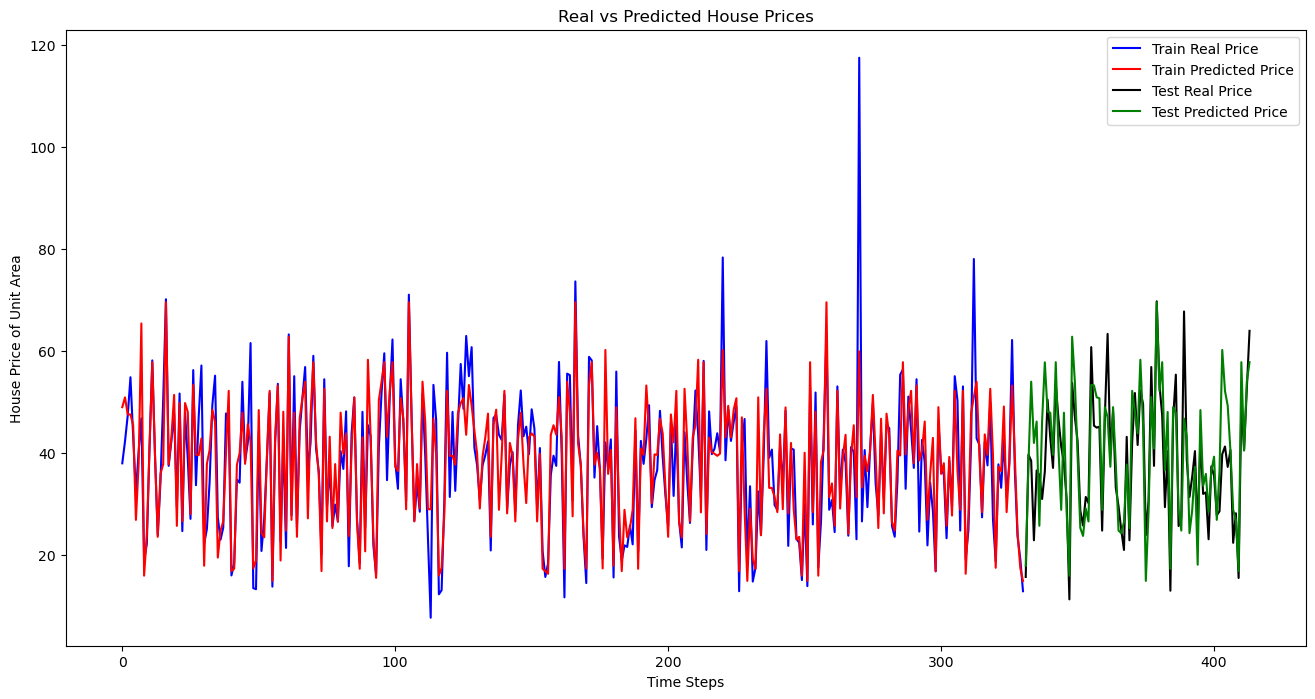

In [30]:
# KNN模型沒有訓練和驗證損失曲線可畫，因為它不是基於迭代優化的模型
# 繪製訓練集的真實房價和預測房價
plt.figure(figsize=(16, 8))

# 訓練集的預測
plt.plot(np.arange(len(y_train_actual)), y_train_actual, label='Train Real Price', color='blue')
plt.plot(np.arange(len(train_predict)), train_predict, label='Train Predicted Price', color='red')

# 測試集的預測
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, label='Test Real Price', color='black')
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(test_predict)), test_predict, label='Test Predicted Price', color='green')

plt.title('Real vs Predicted House Prices')
plt.xlabel('Time Steps')
plt.ylabel('House Price of Unit Area')
plt.legend()
plt.show()